In [28]:
# import packages

import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline     
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn
import tigramite
from tigramite.data_processing import DataFrame
from tigramite import data_processing as pp
from tigramite.toymodels import structural_causal_processes as toys
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr

D:\Anaconda\Anaconda3\lib\site-packages\tigramite\plotting.py:26: UserWarning: [Errno 2] No such file or directory: 'D:\\Anaconda\\Anaconda3\\lib\\site-packages\\tigramite\\..\\versions.py'
  warnings.warn(str(e))
D:\Anaconda\Anaconda3\lib\site-packages\tigramite\independence_tests\gpdc.py:27: UserWarning: [Errno 2] No such file or directory: 'D:\\Anaconda\\Anaconda3\\lib\\site-packages\\tigramite\\independence_tests\\..\\..\\versions.py'
  warnings.warn(str(e))
D:\Anaconda\Anaconda3\lib\site-packages\tigramite\independence_tests\gpdc_torch.py:33: UserWarning: [Errno 2] No such file or directory: 'D:\\Anaconda\\Anaconda3\\lib\\site-packages\\tigramite\\independence_tests\\..\\..\\versions.py'
  warnings.warn(str(e))


In [2]:
# load data
df = pd.read_excel(r'Temp.xlsx')
df.head()

,B,C,H,K-O,NEA
0,17.532686,15.239167,18.032292,15.285419,12.567620
1,17.286786,15.876019,19.927739,14.729940,12.702126
2,17.247153,15.530041,17.589723,15.013688,12.506792
3,16.829063,14.976965,16.857501,14.813846,13.100084
4,16.937153,15.440570,18.270626,15.132383,12.487937


In [57]:
# acquire minimum sst
min_temp = (df.min(axis = 1)).min(axis = 0)
min_temp

12.052302405948

In [6]:
df_1 = (pd.read_excel(r'Benguela-FAO.xlsx')).drop(columns=['year','region-FAO'])
df_2 = (pd.read_excel(r'California-FAO.xlsx')).drop(columns=['year','region-FAO'])
df_3 = (pd.read_excel(r'Humboldt-FAO.xlsx')).drop(columns=['year','region-FAO'])
df_4 = (pd.read_excel(r'Kuroshio-Oyashio-FAO.xlsx')).drop(columns=['year','region-FAO'])
df_5 = (pd.read_excel(r'NE Atlantic-FAO.xlsx')).drop(columns=['year','region'])

In [19]:
def stand_sca(data):
    # Normalization
    new_data=(data-data.mean())/data.std()
    return new_data

In [83]:
# Generate clips based on ΔSST for each current
def Generate(dataframe, minTem, SIZE, deltaT):
    
    # SIZE = 8
    # deltaT = 0.9

    dfs = []
    
    for i in range(0, SIZE):
        # 对前面序列按上下界处理
        if i < SIZE-1:
            df = dataframe.loc[(dataframe['temp'] >= minTem + i * deltaT) & (dataframe['temp'] < minTem + (i+1) * deltaT)]
        # 对最后一个区间只设置下界
        else:
            df = dataframe.loc[(dataframe['temp'] >= minTem + i * deltaT)]
        print(len(df))
        # 筛选长度大于0的序列，并标准化处理
        if len(df) > 0:
            df = stand_sca(df)
            dfs.append(df)
    
    return dfs

In [240]:
b = Generate(df_5, min_temp, 6, 1.2)
b

50
15
0
0
0
0


[    A.landings  S.landing-sum      temp  sea_level
 0    -0.032303      -0.647932 -0.548059  -1.122972
 1     0.236861      -0.375955 -0.064845  -1.074048
 2     0.141669       0.072148 -0.766581  -1.028871
 3     0.768625      -0.692263  1.364821  -1.007395
 4     0.348466       0.189566 -0.834318  -0.969576
 5     0.532286      -0.011721  0.486305  -0.918018
 6     0.965575       1.176830  0.006356  -0.855519
 8     1.782916       1.953223  0.641680  -0.619017
 9     2.518195       2.137736  1.070279  -0.602483
 10    1.943758       1.284663 -0.869530  -0.528065
 11    1.018095       1.022271 -2.399338  -0.603569
 12    2.107883       1.790276  0.300392  -0.674756
 13    2.836596       1.197199 -1.334754  -0.806215
 14    1.533446       0.964760  0.277110  -0.905882
 15    1.142830       0.713151 -0.633873  -0.942209
 16    0.332054      -0.263330  0.177304  -0.892307
 17    0.161364      -0.582034  0.328814  -0.793536
 18    0.108844      -0.973825 -0.294698  -0.706630
 19   -0.459

In [231]:
#运行PCMCI
def Run_PCMCI(file):
    
    # raw values from csv 
    dataset1 = file.to_numpy()

    # variable names
    var_names = [r'$A.landing$', r'$S.landing$', r'$temp.mean$', r'$sea_level$']

    # generate the dataframe
    dataframe_y = DataFrame({1: dataset1}, analysis_mode='multiple', var_names=var_names)
    
    for member in dataframe_y.values.keys():
        tp.plot_timeseries(selected_dataset = member, dataframe = dataframe_y)
        plt.show()
    
    # use Partial Correlation as the Conditional Independence test
    parcorr = ParCorr(significance='analytic')
    pcmci = PCMCI(
        dataframe=dataframe_y, 
        cond_ind_test=parcorr,
        verbosity=1)
    
    # plot the the lagged correlations
    correlations = pcmci.get_lagged_dependencies(tau_max=4, val_only=True)['val_matrix']
    lag_func_matrix = tp.plot_lagfuncs(val_matrix=correlations, setup_args={'var_names':var_names, 
                                        'x_base':5, 'y_base':.5, 'figsize':(8, 6)}); plt.show()
    
    return pcmci

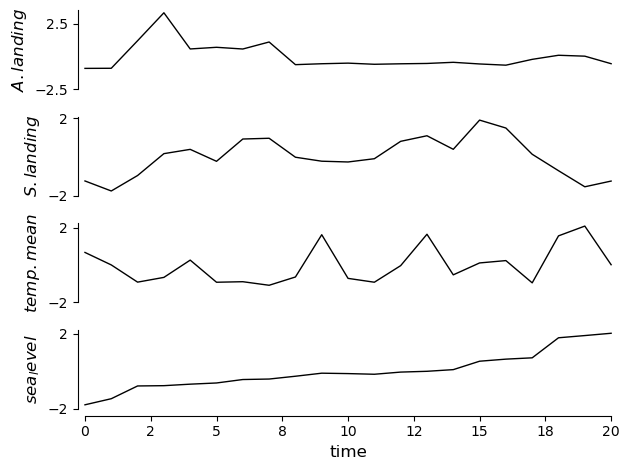


##
## Estimating lagged dependencies 
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4


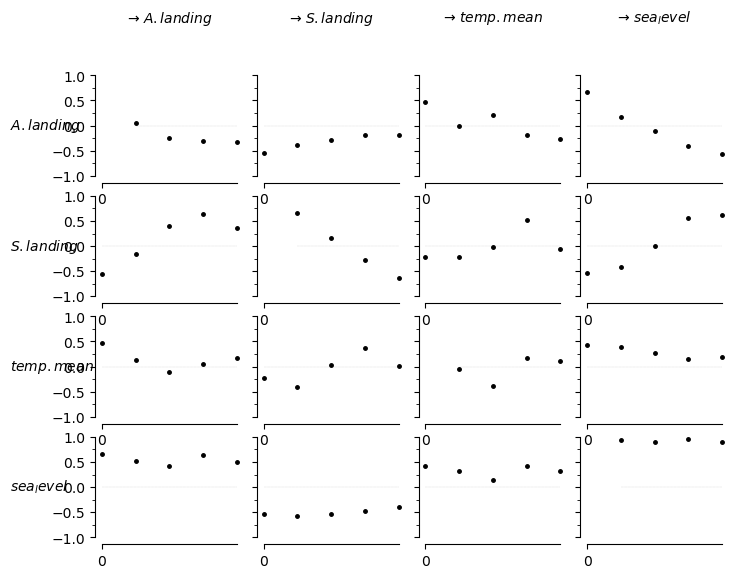

In [232]:
pcmci = Run_PCMCI(c[2])

In [55]:
# 探测网络MCI总和的变化，以及pc_alpha总和变化
def Net_Entropy(pcmci, max_tau):

    mci_dif_tau = []

    for tau_var in range(0, max_tau + 1):
        # construct mci_sum set
        mcisum = []
        results = pcmci.run_pcmci(tau_max=tau_var, pc_alpha=[0.01,0.05,0.1,0.2,0.3,0.4,0.5])
        mci_all = results['val_matrix'].round(2)
        mci_var = []
        for i in range(len(mci_all)):
            mci_var.append(np.mean(mci_all[i], axis=1))
        mci_var = np.array(mci_var)
        # see mci_matrix
        print(mci_var)
        # compute sum of mci
        mcisum.append(np.sum(mci_var))
        print(np.sum(mci_var))
        # store mcisum for each tau_max
        mci_dif_tau.append(mcisum)
        
    plt.figure(figsize = (12,9))
    plt.plot(np.arange(0,max_tau + 1,1), mci_dif_tau)
    plt.title('sum of MCI variability with different tau_max')
    plt.xlabel('tau_max')
    plt.ylabel('sum of MCI')
    plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $S.landing$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $temp.mean$ has 0 link(s):
    [pc_alpha = 0.01]

    Variable $sea_level$ has 0 link(s):
    [pc_alpha = 0.01]

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 0
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable $A.landing$ has 0 link(s):

    Variable $S.landing$ has 0 link(s):

    Variable $temp.mean$ has 0 link(s):

    Variable $sea_level$ has 0 link(s):
[[ 0.    0.07 -0.31 -0.18]
 [ 0.07  0.   -0.2   0.  ]
 [-0.31 -0.2   0.    0.39]
 [-0.18  0.    0.39  0.  ]]
-0.46

##
## Step 1: PC1 algorithm with la

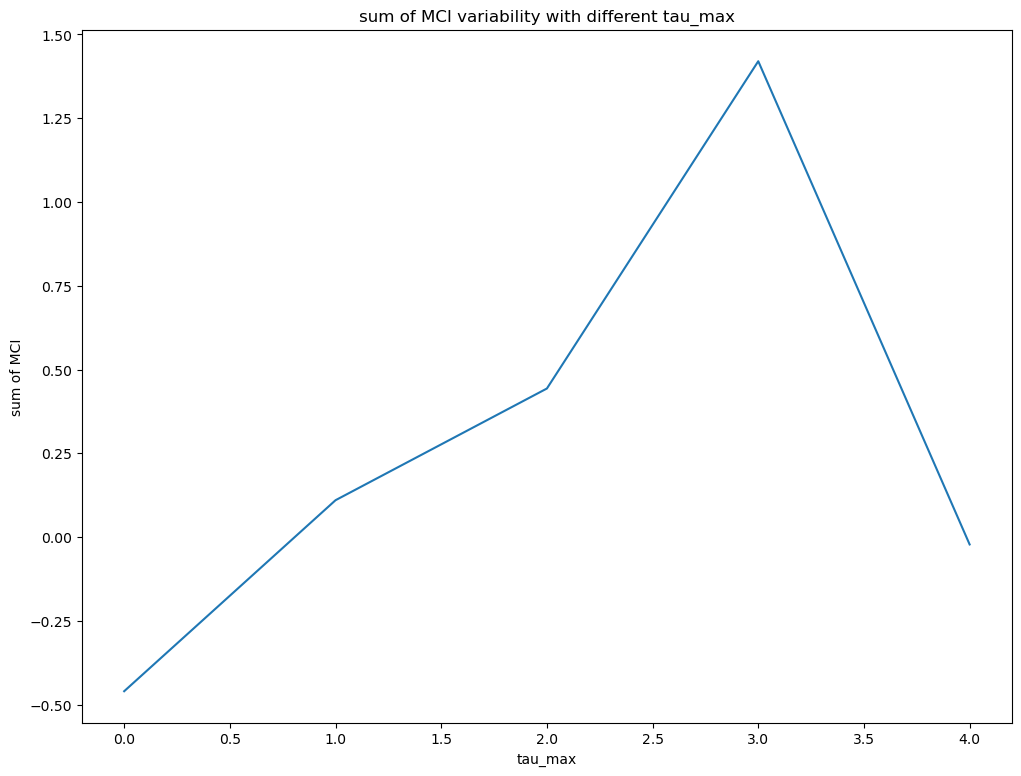

In [233]:
Net_Entropy(pcmci, 4)

In [98]:
# 输出网络MCI方差
def Net_Var(pcmci, max_tau):
    mci_difvar_tau = []

    for tau_var in range(0, max_tau + 1):
        # construct mci_sum set
        mcisum = []
        for alpha in np.linspace(0.1, 0.51, 10, endpoint=False):
            results = pcmci.run_pcmci(tau_max=tau_var, alpha_level=0.05, pc_alpha=alpha)
            mci_all = results['val_matrix'].round(2)
            mci_var = []
            for i in range(len(mci_all)):
                mci_var.append(np.mean(mci_all[i], axis=1))
            mci_var = np.array(mci_var)
            # compute sum of mci
            mcisum.append(np.sum(mci_var))
        # store variance of mcisum for each tau_max
        mci_difvar_tau.append(np.var(mcisum))

    x = np.linspace(0, max_tau + 1, max_tau + 1, endpoint=False)
    y = np.array(mci_difvar_tau).round(5)

    plt.figure(figsize=(12,8))
    plt.bar(x, y)
    for a, b in zip(x, y):
        plt.text(a, b, b, ha='center', va='bottom')
    plt.xlabel('tau_max')
    plt.ylabel('variance of MCI_SUM with different pc_alpha')
    plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.1]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 0 link(s):

    Variable $S.landing$ has 0 link(s):

    Variable $temp.mean$ has 0 link(s):

    Variable $sea_level$ has 0 link(s):

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 0
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable $A.landing$ has 0 link(s):

    Variable $S.landing$ has 0 link(s):

    Variable $temp.mean$ has 0 link(s):

    Variable $sea_level$ has 0 link(s):

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 0
pc_alpha = [0.14100000000000001]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 0 


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
        ($sea_level$ -1): max_pval = 0.10202, min_val = -0.398
        ($S.landing$ -1): max_pval = 0.11568, min_val = -0.373
        ($A.landing$ -1): max_pval = 0.13097, min_val =  0.370

    Variable $S.landing$ has 3 link(s):
        ($S.landing$ -1): max_pval = 0.00600, min_val =  0.621
        ($temp.mean$ -1): max_pval = 0.32631, min_val = -0.253
        ($sea_level$ -1): max_pval = 0.34838, min_val = -0.242

    Variable $temp.mean$ has 1 link(s):
        ($sea_level$ -1): max_pval = 0.03356, min_val =  0.489

    Variable $sea_level$ has 3 link(s):
        ($sea_level$ -1): max_pval = 0.00000, min_val =  0.944
        ($temp.mean$ -1): max_pval = 0.26569, min_val = -0.277
        ($A.landing$ -1): max_pval = 0.41878, min_val = -0.203

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 1
max_conds_py = None
max_conds_px = None

## Significant links at a


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 2 link(s):
        ($A.landing$ -2): max_pval = 0.11699, min_val =  0.408
        ($A.landing$ -1): max_pval = 0.12902, min_val =  0.396

    Variable $S.landing$ has 2 link(s):
        ($S.landing$ -1): max_pval = 0.04590, min_val =  0.522
        ($sea_level$ -1): max_pval = 0.30139, min_val = -0.286

    Variable $temp.mean$ has 2 link(s):
        ($sea_level$ -1): max_pval = 0.35377, min_val =  0.258
        ($temp.mean$ -2): max_pval = 0.33035, min_val = -0.251

    Variable $sea_level$ has 2 link(s):
        ($sea_level$ -1): max_pval = 0.00746, min_val =  0.641
        ($temp.mean$ -1): max_pval = 0.06174, min_val =  0.462

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 2
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable $A.landing$ has 0 link(s):

    Variable $S.landing$ has 1 link(s):
        ($S.landing$ -1): pval 


## Significant links at alpha = 0.05:

    Variable $A.landing$ has 0 link(s):

    Variable $S.landing$ has 0 link(s):

    Variable $temp.mean$ has 0 link(s):

    Variable $sea_level$ has 2 link(s):
        ($sea_level$ -3): pval = 0.00061 | val =  0.937
        ($A.landing$ -1): pval = 0.01212 | val =  0.752

##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.264]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 1 link(s):
        ($A.landing$ -1): max_pval = 0.19524, min_val =  0.368

    Variable $S.landing$ has 3 link(s):
        ($sea_level$ -1): max_pval = 0.05302, min_val = -0.527
        ($S.landing$ -1): max_pval = 0.14698, min_val =  0.426
        ($temp.mean$ -3): max_pval = 0.19602, min_val =  0.354

    Variable $temp.mean$ has 2 link(s):
        ($sea_level$ -3): max_pval = 0.15490, min_val =  0.401
        ($S.landing$ -


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 2 link(s):
        ($sea_level$ -3): max_pval = 0.08388, min_val =  0.519
        ($S.landing$ -3): max_pval = 0.08936, min_val =  0.511

    Variable $S.landing$ has 2 link(s):
        ($S.landing$ -1): max_pval = 0.05110, min_val =  0.574
        ($S.landing$ -4): max_pval = 0.06466, min_val = -0.549

    Variable $temp.mean$ has 1 link(s):
        ($S.landing$ -3): max_pval = 0.07314, min_val =  0.513

    Variable $sea_level$ has 2 link(s):
        ($sea_level$ -3): max_pval = 0.00812, min_val =  0.721
        ($S.landing$ -3): max_pval = 0.04994, min_val =  0.576

##
## Step 2: MCI algorithm
##

Parameters:

independence test = par_corr
tau_min = 0
tau_max = 4
max_conds_py = None
max_conds_px = None

## Significant links at alpha = 0.05:

    Variable $A.landing$ has 2 link(s):
        ($S.landing$ -2): pval = 0.02296 | val =  0.704
        ($S.landing$  0): pval = 0.04661 | val = -0.674 | unoriented link

    


## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
        ($sea_level$ -3): max_pval = 0.20151, min_val =  0.417
        ($S.landing$ -2): max_pval = 0.17535, min_val =  0.400
        ($sea_level$ -2): max_pval = 0.31177, min_val = -0.336

    Variable $S.landing$ has 3 link(s):
        ($S.landing$ -1): max_pval = 0.10089, min_val =  0.548
        ($S.landing$ -4): max_pval = 0.23343, min_val = -0.392
        ($temp.mean$ -3): max_pval = 0.33812, min_val =  0.303

    Variable $temp.mean$ has 3 link(s):
        ($S.landing$ -3): max_pval = 0.19286, min_val =  0.404
        ($temp.mean$ -2): max_pval = 0.19425, min_val = -0.403
        ($A.landing$ -4): max_pval = 0.41729, min_val = -0.258

    Variable $sea_level$ has 4 link(s):
        ($sea_level$ -3): max_pval = 0.00812, min_val =  0.721
        ($S.landing$ -3): max_pval = 0.08465, min_val =  0.571
        ($A.landing$ -3): max_pval = 0.20895, min_val =  0.435
        ($sea_level$ -1): max_pval = 0.

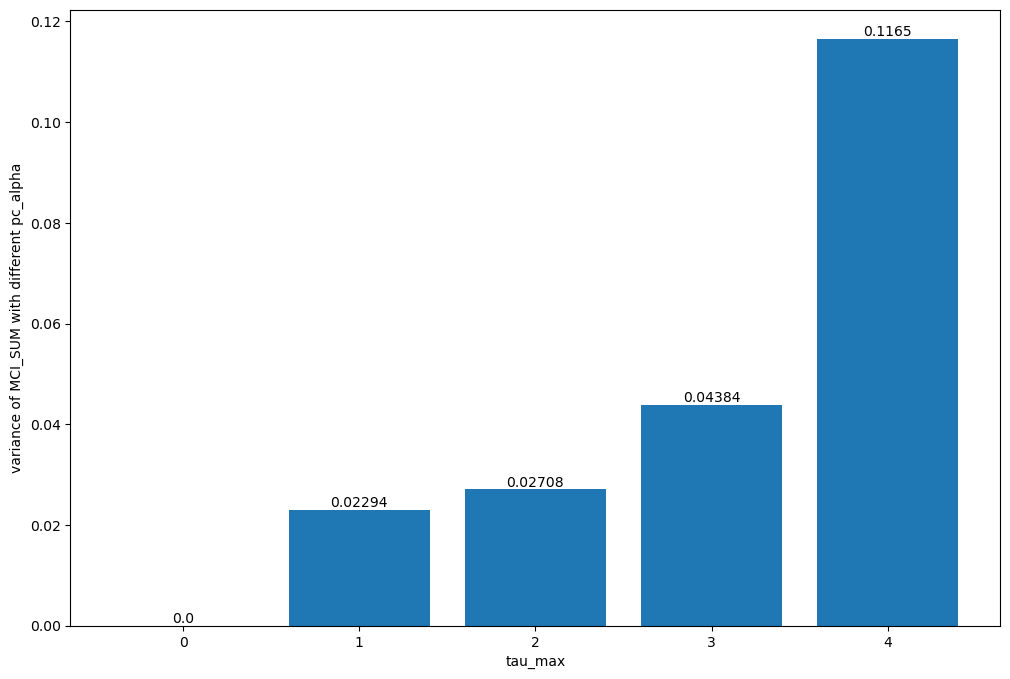

In [234]:
Net_Var(pcmci, 4)

In [182]:
def pcmci_plot(pcmci, tau):
    
    var_names = [r'$A.landing$', r'$S.landing$', r'$temp.mean$', r'$sea_level$']
    
    link_matrix = pcmci.run_pcmci(tau_max=tau, alpha_level=0.05, pc_alpha=[0.01,0.05,0.1,0.2,0.3,0.4,0.5])
    # Plot casual network
    tp.plot_graph(
        figsize=(12,8),
        graph=link_matrix.get("graph"),
        val_matrix=link_matrix['val_matrix'],
        var_names=var_names,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        ); plt.show()

    # Plot time series graph    
    tp.plot_time_series_graph(
        graph=link_matrix.get("graph"),
        figsize=(16, 12),
        val_matrix=link_matrix['val_matrix'],
        var_names=var_names,
        link_colorbar_label='MCI',
        ); plt.show()


##
## Step 1: PC1 algorithm with lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 4
pc_alpha = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable $A.landing$ has 3 link(s):
    [pc_alpha = 0.4]
        ($sea_level$ -3): max_pval = 0.20151, min_val =  0.417
        ($S.landing$ -2): max_pval = 0.17535, min_val =  0.400
        ($sea_level$ -2): max_pval = 0.31177, min_val = -0.336

    Variable $S.landing$ has 3 link(s):
    [pc_alpha = 0.4]
        ($S.landing$ -1): max_pval = 0.10089, min_val =  0.548
        ($S.landing$ -4): max_pval = 0.23343, min_val = -0.392
        ($temp.mean$ -3): max_pval = 0.33812, min_val =  0.303

    Variable $temp.mean$ has 4 link(s):
    [pc_alpha = 0.5]
        ($temp.mean$ -2): max_pval = 0.19425, min_val = -0.403
        ($S.landing$ -3): max_pval = 0.42232, min_val =  0.286
        ($sea_level$ -3): max_pval = 0.44400, min_val =

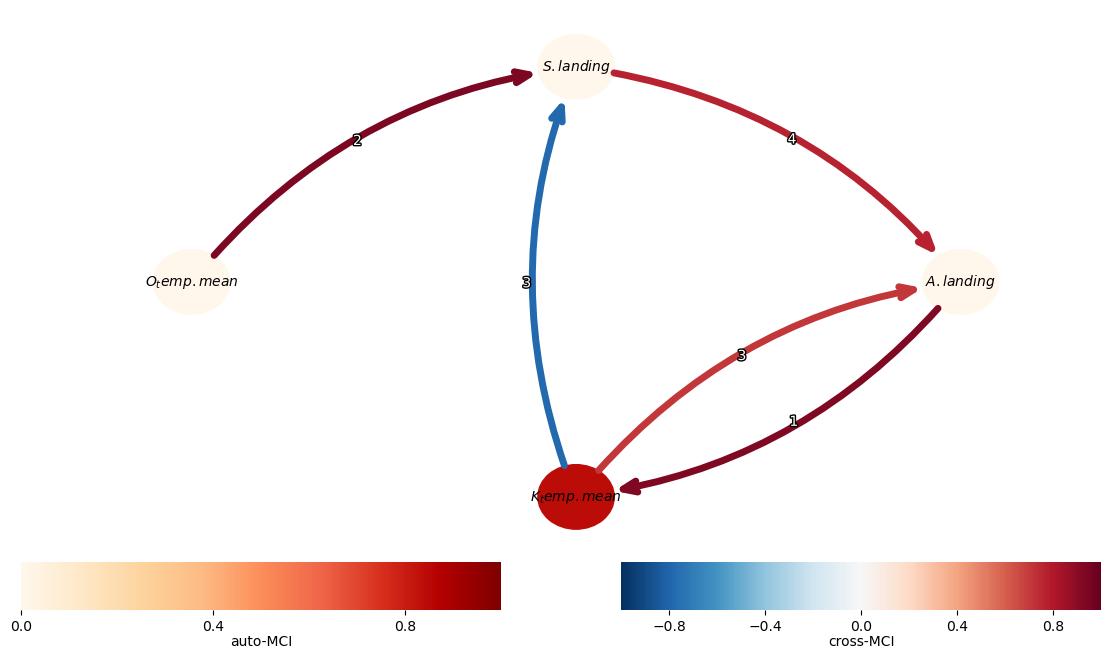

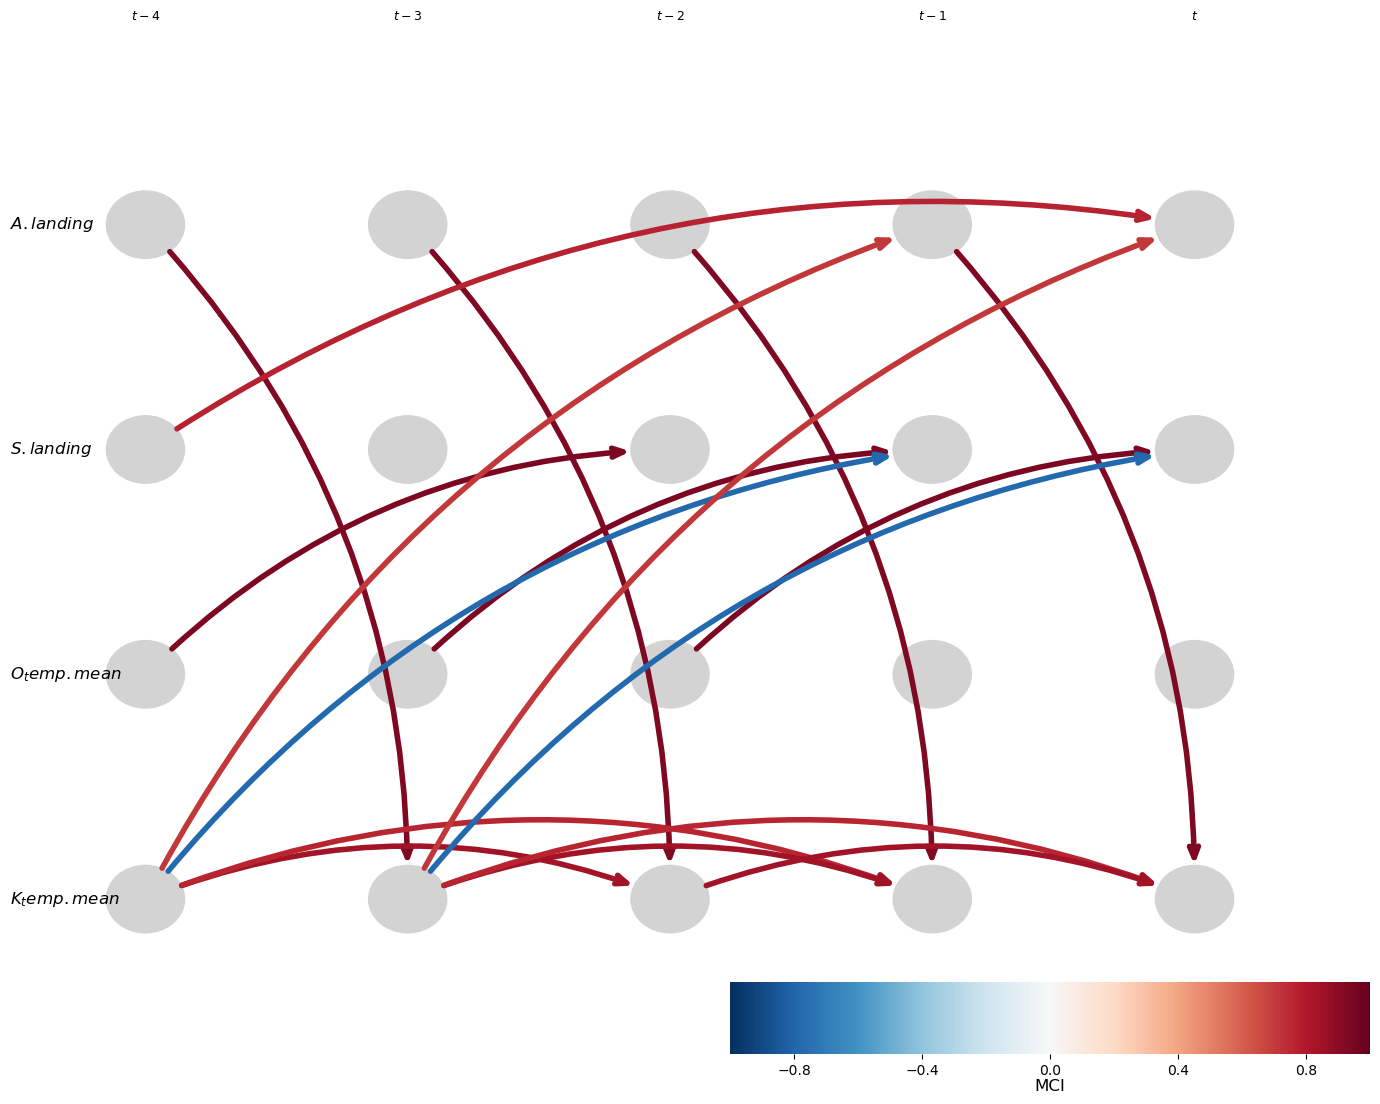

In [236]:
pcmci_plot(pcmci, 4)